# Imoport Libraries

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
import time
import keras
import math
import json 

from shutil import copy
from PIL import Image

sys.path.insert(1, '../../utils')
#from Nutrition5kDataPrep import prepare_data, create_dataset

from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dropout, Dense, GlobalAveragePooling2D, Concatenate
from tensorflow.keras import datasets, layers, models
from keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
import sklearn.metrics as sklm

# Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir("./drive/MyDrive/Nutrition5k")

Mounted at /content/drive


In [ ]:
# Helper method to split dataset into train and test folders
def prepare_data(filepath, src, dest):
    with open(filepath, 'r') as txt:
        paths = [read.strip()+'/rgb.png' for read in txt.readlines()]

    if not os.path.exists(dest):
        os.makedirs(dest)

    for food in paths:
        out = food.split('/')
        dest_name = out[0]+'.png'
        src_path = os.path.join(src,food)
        dest_path = os.path.join(dest,dest_name)

        if (not os.path.exists(dest_path)) and os.path.exists(src_path):
            # print("\nCopying images into ", dest_name)
            copy(os.path.join(src,food), os.path.join(dest,dest_name))

    print("Copying Done!")


def create_dataset(filenames, labels,
                   is_training=True,
                   img_size = 224, channels = 3, batch_size = 256, buffer_size = 1024):
  # 
    """Load and parse dataset.
    Args:
        filenames: list of image paths
        labels: numpy array of shape (BATCH_SIZE, N_LABELS)
        is_training: boolean to indicate training mode
    """

    # Create a first dataset of file paths and labels
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    AUTOTUNE = tf.data.experimental.AUTOTUNE # Adapt preprocessing and prefetching dynamically
    # Parse and preprocess observations in parallel
    dataset = dataset.map(lambda x, y: parse_function(x, y, img_size=img_size, channels=channels),
                          num_parallel_calls=AUTOTUNE)

    if is_training == True:
        # This is a small dataset, only load it once, and keep it in memory.
        dataset = dataset.cache()
        # Shuffle the data each buffer size
        dataset = dataset.shuffle(buffer_size=buffer_size)

    # Batch the data for multiple steps
    dataset = dataset.batch(batch_size=batch_size)
    # Fetch batches in the background while the model is training.
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)

    return dataset
    
def parse_function(filename, label, img_size = 224, channels = 3):
    """Function that returns a tuple of normalized image array and labels array.
    Args:
        filename: string representing path to image
        label: 0/1 one-dimensional array of size N_LABELS
    """
    # Read an image from a file
    image_string = tf.io.read_file(filename)
    # Decode it into a dense vector
    image_decoded = tf.io.decode_png(image_string, channels=channels)
    # Resize it to fixed shape
    image_resized = tf.image.resize(image_decoded, [img_size, img_size])
    # Normalize it from [0, 255] to [0.0, 1.0]
    image_normalized = image_resized / 255.0
    return image_normalized, label

In [ ]:
# Prepare train dataset
print("Creating train data...")
filepath = './data/Nutrition5k/dish_ids/splits/rgb_train_ids.txt' # directory to rgb_train_ids.txt
src = './data/Nutrition5k/realsense_overhead'                     # directory to images 
dest = './data/Nutrition5k/train_rgb'                             # directory to train_rgb folder
prepare_data(filepath, src, dest)

# Prepare test dataset
print("Creating test data...")
filepath = './data/Nutrition5k/dish_ids/splits/rgb_test_ids.txt' # directory to rgb_test_ids.txt
src = './data/Nutrition5k/realsense_overhead'                    # directory to images 
dest = './data/Nutrition5k/test_rgb'                             # directory to test_rgb folder
prepare_data(filepath, src, dest)

# read specified labels
labels = pd.read_csv('./data/Nutrition5k/nutrition5k_10_visible_ingr_calorie.csv')#.iloc[: , 1:]
labels['dish_id'] = labels['dish_id'] + '.png'
ingred = labels.iloc[: , 1:].columns

Creating train data...
Copying Done!
Creating test data...
Copying Done!


# Data Preparation

## Add Binary Labels

In [ ]:
def add_binary_labels(ds):
  ds.columns = ['dish_id', 'garlic_calories', 'spinach (raw)_calories', 'cheese pizza_calories', 'olives_calories',\
       'cilantro_calories', 'roasted potatoes_calories', 'corn on the cob_calories', 'sausage_calories', 'tofu_calories',\
       'chicken breast_calories']
  ingredients = ['garlic', 'spinach (raw)', 'cheese pizza', 'olives',\
       'cilantro', 'roasted potatoes', 'corn on the cob', 'sausage', 'tofu',\
       'chicken breast']
  for i in ingredients: 
    col_name = f'{i}_calories'
    binary_col_name = f'{i}_binary'
    threshold = 0 # Change this to your desired threshold
    ds[binary_col_name] = (ds[col_name] > threshold).astype(int)
  return ds

labels = add_binary_labels(labels)

In [ ]:
# split dataset into train and val
train_dest = './data/Nutrition5k/train_rgb'
test_dest = './data/Nutrition5k/test_rgb'

#X_train = [os.path.join(train_dest, img) for img in os.listdir(train_dest)]
#X_val = [os.path.join(test_dest, img) for img in os.listdir(test_dest)]

y_train = labels.loc[labels.dish_id.isin(os.listdir(train_dest))]\
                .set_index('dish_id').reindex(os.listdir(train_dest))\
                .to_numpy().tolist()

y_val = labels.loc[labels.dish_id.isin(os.listdir(test_dest))]\
                .set_index('dish_id').reindex(os.listdir(test_dest))\
                .to_numpy().tolist()
arr_y_val = np.array(y_val)

In [ ]:
pd.DataFrame(y_train).describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
count,2755.000000,2755.000000,2755.000000,2755.000000,2755.000000,2755.000000,2755.00000,2755.000000,2755.000000,2755.000000,2755.00000,2755.000000,2755.000000,2755.000000,2755.000000,2755.000000,2755.000000,2755.000000,2755.000000,2755.000000
mean,0.550192,0.633083,14.732115,3.429623,0.014063,4.775575,3.14911,8.449267,1.386073,2.022744,0.29510,0.130672,0.082396,0.066788,0.058076,0.050091,0.037387,0.030853,0.024319,0.014156
std,1.447911,2.598044,54.287872,16.436805,0.068854,23.322968,17.69698,50.985420,9.847303,18.302030,0.45617,0.337102,0.275016,0.249699,0.233930,0.218172,0.189742,0.172951,0.154067,0.118156
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.463058,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,14.746660,27.213214,465.325000,148.350000,0.762687,227.010000,207.95600,454.872000,185.420000,295.799579,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Scaling: std-mean 

In [ ]:
# scale labels by std and mean of training ingredients
std_by_label = pd.DataFrame(y_train).describe().iloc[2]
print(std_by_label)
mean_by_label = pd.DataFrame(y_train).describe().iloc[1]
print(mean_by_label)
for idx,i in enumerate(labels.columns[1:11]):
    labels[i] = labels[i].apply(lambda x: (x - mean_by_label[idx]) / std_by_label[idx])

0      1.447911
1      2.598044
2     54.287872
3     16.436805
4      0.068854
5     23.322968
6     17.696980
7     50.985420
8      9.847303
9     18.302030
10     0.456170
11     0.337102
12     0.275016
13     0.249699
14     0.233930
15     0.218172
16     0.189742
17     0.172951
18     0.154067
19     0.118156
Name: std, dtype: float64
0      0.550192
1      0.633083
2     14.732115
3      3.429623
4      0.014063
5      4.775575
6      3.149110
7      8.449267
8      1.386073
9      2.022744
10     0.295100
11     0.130672
12     0.082396
13     0.066788
14     0.058076
15     0.050091
16     0.037387
17     0.030853
18     0.024319
19     0.014156
Name: mean, dtype: float64


## Scaling: Min-max

In [ ]:
# min-max normalization
max_by_label = pd.DataFrame(y_train).describe().iloc[-1]
#print(max_by_label)
min_by_label = pd.DataFrame(y_train).describe().iloc[3]
#print(min_by_label)
for idx,i in enumerate(labels.columns[1:11]):
    labels[i] = labels[i].apply(lambda x: (x - min_by_label[idx]) / (max_by_label[idx] - min_by_label[idx]))

In [ ]:
# to calculate relative error, we need std
std_by_label = pd.DataFrame(y_train).describe().iloc[2]

## Split datasets

In [ ]:
# split dataset into train and val
train_dest = './data/Nutrition5k/train_rgb'
test_dest = './data/Nutrition5k/test_rgb'

X_train = [os.path.join(train_dest, img) for img in os.listdir(train_dest)]
X_val = [os.path.join(test_dest, img) for img in os.listdir(test_dest)]

y_train = labels.loc[labels.dish_id.isin(os.listdir(train_dest))]\
                .set_index('dish_id').reindex(os.listdir(train_dest))\
                .to_numpy().tolist()

y_val = labels.loc[labels.dish_id.isin(os.listdir(test_dest))]\
                .set_index('dish_id').reindex(os.listdir(test_dest))\
                .to_numpy().tolist()
arr_y_val = np.array(y_val)

nobs = 8 # Maximum number of images to display
ncols = 4 # Number of columns in display
nrows = nobs//ncols # Number of rows in display

# define some params
IMG_SIZE = 224 # Specify height and width of image to match the input format of the model
CHANNELS = 3 # Keep RGB color channels to match the input format of the model
BATCH_SIZE = 64
AUTOTUNE = tf.data.experimental.AUTOTUNE # Adapt preprocessing and prefetching dynamically
SHUFFLE_BUFFER_SIZE = 1024 # Shuffle the training data by a chunck of 1024 observations

# create datasets
train_ds = create_dataset(X_train, y_train, is_training=True,
                          img_size = IMG_SIZE, channels = CHANNELS,
                          batch_size = BATCH_SIZE,
                          buffer_size = SHUFFLE_BUFFER_SIZE)

val_ds = create_dataset(X_val, y_val,
                        img_size = IMG_SIZE, channels = CHANNELS,
                        batch_size = BATCH_SIZE, buffer_size = SHUFFLE_BUFFER_SIZE)

for f, l in train_ds.take(1):
    print("Shape of features array:", f.numpy().shape)
    print("Shape of labels array:", l.numpy().shape)

Shape of features array: (64, 224, 224, 3)
Shape of labels array: (64, 20)


## Data Augmentation

In [ ]:
data_augmentation = Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2)
])

Text(0.5, 1.0, 'Augmented Image')

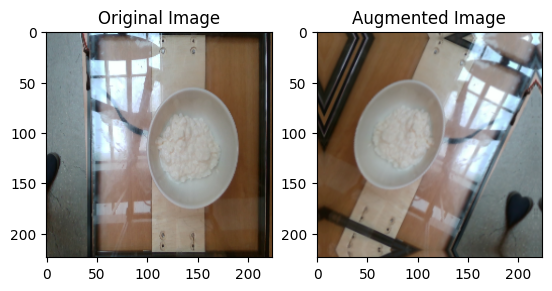

In [ ]:
sample_batch = next(iter(train_ds))
sample_image = sample_batch[0][0]
sample_label = sample_batch[1][0]

plt.subplot(1, 2, 1)
plt.imshow(sample_image.numpy())
plt.title("Original Image")

plt.subplot(1, 2, 2)
augmented_image = data_augmentation(sample_image)
plt.imshow(augmented_image.numpy())
plt.title("Augmented Image")

In [ ]:
# resize the data
train_ds = train_ds.map(lambda x,y:(data_augmentation(x), y))
train_ds = train_ds.map(lambda x,y: (tf.image.resize(x, (75,75)),y))
val_ds = val_ds.map(lambda x,y: (tf.image.resize(x, (75,75)),y))

# Classification + Regression

## Metrics

In [ ]:
# when scale is standardization, param1 is std, param2 is mean
# when scale is normalization, param1 is min, param2 is max
class self_Accuracy(tf.keras.metrics.Metric):

    def __init__(self, label, name='accuracy_by_label_'):
        super(self_Accuracy, self).__init__(name=name)
        self.label = label
        self.correct = self.add_weight(name='correct', initializer='zeros')
        self.total = self.add_weight(name='total', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        """
        Called at the end of each batch:
        calculates number of correct prediction and total number of predictions
        """
        # number of correct predictions
        y_true_bin = y_true[:, y_true.shape[1]//2:]
        y_pred_logit = y_pred[:, y_true.shape[1]//2:]
        y_pred_prob = tf.nn.sigmoid(y_pred_logit)
        y_pred_bin = tf.where(y_pred_prob>0.5,1,0)
        self.correct.assign_add(tf.keras.metrics.binary_accuracy(tf.cast(y_true_bin[:,self.label],tf.float32), 
                                tf.cast(y_pred_bin[:,self.label],tf.float32)) 
                                * tf.cast(tf.size(y_pred_bin),tf.float32))
        # total number of predictions 
        self.total.assign_add(tf.cast(tf.size(y_pred_bin),tf.float32))
        
    def result(self):
        return self.correct / self.total
    
    def reset_state(self):
        """
        reset variables between epochs
        """
        self.correct.assign(0)
        self.total.assign(0)

class self_MSE(tf.keras.metrics.Metric):
    """
    Calculates total MSE for a label.
    NOTE: we need to calculate average later separately
          by dividing total MSE for a label by the number of batches

    """
    def __init__(self, class_id, param1, param2, scale = "standardization", name='mse_by_label_', **kwargs):
        super(self_MSE, self).__init__(name=name, **kwargs)
        # when scale is standardization, param1 is std, param2 is mean
        # when scale is normalization, param1 is min, param2 is max
        self.scale = scale 
        self.param1 = param1
        self.param2 = param2
        self.class_id = class_id
        self.mse = self.add_weight(name='mse', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true_bin = y_true[:, y_true.shape[1]//2:]
        y_pred_logit = y_pred[:, y_true.shape[1]//2:]
        y_pred_prob = tf.nn.sigmoid(y_pred_logit)
        y_pred_bin = tf.where(y_pred_prob>0.5,1,0)
        # Extract calorie values from y_true
        z_true = y_true[:, :y_true.shape[1]//2]
        z_pred = y_pred[:, :y_true.shape[1]//2]
        if self.scale == "standardization":
          z_true = tf.cast(z_true[:,self.class_id], tf.float32) * self.param1[self.class_id]+self.param2[self.class_id]
          z_pred = tf.cast(z_pred[:,self.class_id], tf.float32) * self.param1[self.class_id]+self.param2[self.class_id]
        elif self.scale == "normalization":
          z_true = tf.cast(z_true[:,self.class_id], tf.float32) * (self.param2[self.class_id] - self.param1[self.class_id]) + self.param1[self.class_id]
          z_pred = tf.cast(z_pred[:,self.class_id], tf.float32) * (self.param2[self.class_id] - self.param1[self.class_id]) + self.param1[self.class_id]
        else: 
          z_true = tf.cast(z_true[:,self.class_id], tf.float32)
          z_pred = tf.cast(z_pred[:,self.class_id], tf.float32)

        y_pred_bin = tf.cast(y_pred_bin[:,self.class_id], tf.float32)
        regression_loss = tf.square(z_true - y_pred_bin * z_pred)
        mse = tf.reduce_mean(regression_loss, axis=0)
        self.mse.assign_add(mse)

    def result(self):
        return self.mse

    def reset_state(self):
        self.mse.assign(0.)

class self_MAE(tf.keras.metrics.Metric):
    """
    Calculates total MAE for a label.
    NOTE: we need to calculate average later separately
          by dividing total MAE for a label by the number of batches

    """
    def __init__(self, class_id, param1, param2, scale = "standardization", name='mae_by_label_', **kwargs):
        super(self_MAE, self).__init__(name=name, **kwargs)
        self.scale = scale 
        self.param1 = param1
        self.param2 = param2
        self.class_id = class_id
        self.mae = self.add_weight(name='mae', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true_bin = y_true[:, y_true.shape[1]//2:]
        y_pred_logit = y_pred[:, y_true.shape[1]//2:]
        y_pred_prob = tf.nn.sigmoid(y_pred_logit)
        y_pred_bin = tf.where(y_pred_prob>0.5,1,0)
        # Extract calorie values from y_true
        z_true = y_true[:, :y_true.shape[1]//2]
        z_pred = y_pred[:, :y_true.shape[1]//2]
        if self.scale == "standardization":
          z_true = tf.cast(z_true[:,self.class_id], tf.float32) * self.param1[self.class_id]+self.param2[self.class_id]
          z_pred = tf.cast(z_pred[:,self.class_id], tf.float32) * self.param1[self.class_id]+self.param2[self.class_id]
        elif self.scale == "normalization":
          z_true = tf.cast(z_true[:,self.class_id], tf.float32) * (self.param2[self.class_id] - self.param1[self.class_id]) + self.param1[self.class_id]
          z_pred = tf.cast(z_pred[:,self.class_id], tf.float32) * (self.param2[self.class_id] - self.param1[self.class_id]) + self.param1[self.class_id]
        else: 
          z_true = tf.cast(z_true[:,self.class_id], tf.float32)
          z_pred = tf.cast(z_pred[:,self.class_id], tf.float32)

        y_pred_bin = tf.cast(y_pred_bin[:,self.class_id], tf.float32)
        regression_loss = tf.abs(z_true - y_pred_bin * z_pred)
        mae = tf.reduce_mean(regression_loss, axis=0)
        self.mae.assign_add(mae)

    def result(self):
        return self.mae

    def reset_state(self):
        self.mae.assign(0.)


class self_relative_error(tf.keras.metrics.Metric):
    """
    Calculates total MAE for a label.
    NOTE: we need to calculate average later separately
          by dividing total MAE for a label by the number of batches

    """
    def __init__(self, class_id, std, param1, param2, scale = "standardization", name='relative_error_by_label_', **kwargs):
        super(self_relative_error, self).__init__(name=name, **kwargs)
        self.scale = scale 
        self.param1 = param1
        self.param2 = param2
        self.std = std
        self.class_id = class_id
        self.relative_error= self.add_weight(name='relative_error', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true_bin = y_true[:, y_true.shape[1]//2:]
        y_pred_logit = y_pred[:, y_true.shape[1]//2:]
        y_pred_prob = tf.nn.sigmoid(y_pred_logit)
        y_pred_bin = tf.where(y_pred_prob>0.5,1,0)
        # Extract calorie values from y_true
        z_true = y_true[:, :y_true.shape[1]//2]
        z_pred = y_pred[:, :y_true.shape[1]//2]
        if self.scale == "standardization":
          z_true = tf.cast(z_true[:,self.class_id], tf.float32) * self.param1[self.class_id]+self.param2[self.class_id]
          z_pred = tf.cast(z_pred[:,self.class_id], tf.float32) * self.param1[self.class_id]+self.param2[self.class_id]
        elif self.scale == "normalization":
          z_true = tf.cast(z_true[:,self.class_id], tf.float32) * (self.param2[self.class_id] - self.param1[self.class_id]) + self.param1[self.class_id]
          z_pred = tf.cast(z_pred[:,self.class_id], tf.float32) * (self.param2[self.class_id] - self.param1[self.class_id]) + self.param1[self.class_id]
        else: 
          z_true = tf.cast(z_true[:,self.class_id], tf.float32)
          z_pred = tf.cast(z_pred[:,self.class_id], tf.float32)

        y_pred_bin = tf.cast(y_pred_bin[:,self.class_id], tf.float32)
        regression_loss = (tf.abs(z_true - y_pred_bin * z_pred))/ self.std[self.class_id]
        relative_error = tf.reduce_mean(regression_loss, axis=0)
        self.relative_error.assign_add(relative_error)

    def result(self):
        return self.relative_error

    def reset_state(self):
        self.relative_error.assign(0.)

## Custom Loss function

In [ ]:
def combined_loss_mse(y_true, y_pred):

  z_true = y_true[:, :y_true.shape[1]//2]
  z_pred = y_pred[:, :y_true.shape[1]//2]
  
  y_true_bin = y_true[:, y_true.shape[1]//2:]
  y_pred_logit = y_pred[:, y_true.shape[1]//2:]
  y_pred_prob = tf.nn.sigmoid(y_pred_logit)
  y_pred_bin = tf.where(y_pred_prob>0.5,1,0)

    # Compute cross-entropy loss
  ce_loss= tf.nn.sigmoid_cross_entropy_with_logits(labels = y_true_bin, logits = y_pred_logit)
  #ce_loss = tf.keras.losses.binary_crossentropy(y_true_bin, y_pred_prob)

    # Compute regression loss only for predicted active ingredients
  #regression_loss = tf.square(z_true - tf.cast(y_pred_bin, tf.float32) * z_pred)  
  regression_loss = tf.cast(y_pred_bin, tf.float32) * tf.square(z_true - z_pred)
  # reg_loss = tf.reduce_sum(regression_loss, axis=1)

    # Combine the losses
  loss = tf.reduce_mean(ce_loss) + tf.reduce_mean(regression_loss)
  return loss


def combined_loss_mae(y_true, y_pred):

  z_true = y_true[:, :y_true.shape[1]//2]
  z_pred = y_pred[:, :y_true.shape[1]//2]
  
  y_true_bin = y_true[:, y_true.shape[1]//2:]
  y_pred_logit = y_pred[:, y_true.shape[1]//2:]
  y_pred_prob = tf.nn.sigmoid(y_pred_logit)
  y_pred_bin = tf.where(y_pred_prob>0.5,1,0)

    # Compute cross-entropy loss
  ce_loss= tf.nn.sigmoid_cross_entropy_with_logits(labels = y_true_bin, logits = y_pred_logit)
  #ce_loss = tf.keras.losses.binary_crossentropy(y_true_bin, y_pred_prob)

    # Compute regression loss only for predicted active ingredients
  regression_loss = tf.abs(z_true - tf.cast(y_pred_bin, tf.float32) * z_pred)
  # regression_loss = tf.cast(y_pred_bin, tf.float32) * tf.abs(z_true - z_pred)
  # reg_loss = tf.reduce_sum(regression_loss, axis=1)

    # Combine the losses
  loss = tf.reduce_mean(ce_loss) + tf.reduce_mean(regression_loss)
  return loss

## Compile and Fit Model

In [ ]:
input_shape = (75, 75, 3)

# Load the InceptionV3 model with pretrained weights
base_model = InceptionV3(weights='imagenet', input_shape = input_shape, include_top=False)

# Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully-connected layer for binary classification
binary_preds = Dense(10, name='binary_preds')(x)

# Add a fully-connected layer for regression
regression_preds = Dense(10, name='regression_preds')(x)

combined_preds = Concatenate(name='combined_preds')([binary_preds, regression_preds])

model = Model(inputs=base_model.input, outputs=combined_preds)

lr_decayed_fn = tf.keras.experimental.CosineDecay(initial_learning_rate=0.0001, decay_steps=1000)
optimizer_adam_cos_decay = tf.keras.optimizers.Adam(learning_rate=lr_decayed_fn)

# when scale is standardization, param1 is std, param2 is mean
# when scale is normalization, param1 is min, param2 is max
scaling_method = "standardization"
param1 = std_by_label
param2 = mean_by_label
#Compile the model
model.compile(optimizer=optimizer_adam_cos_decay, loss = combined_loss_mae, 
              metrics=[self_Accuracy(label = i, name='acc_{}'.format(i)) for i in range(10)]+
              [self_MSE(class_id = i, param1 = param1, param2 = param2, scale = None, name='mse_{}'.format(i)) for i in range(10)] +
              [self_MAE(class_id = i, param1 = param1, param2 = param2, scale = None, name='mae_{}'.format(i)) for i in range(10)] +
              [self_relative_error(class_id = i, std = std_by_label, param1 = param1, param2 = param2, scale = None, name='relative_error_{}'.format(i)) for i in range(10)] + 
              [self_MSE(class_id = i, param1 = param1, param2 = param2, scale = scaling_method, name='mse_scaled_back_{}'.format(i)) for i in range(10)]+
              [self_MAE(class_id = i, param1 = param1, param2 = param2, scale = scaling_method, name='mae_scaled_back_{}'.format(i)) for i in range(10)] +   
              [self_relative_error(class_id = i, std = std_by_label, param1 = param1, param2 = param2, scale = scaling_method, name='relative_error_scaled_back_{}'.format(i)) for i in range(10)]
              )

In [ ]:
EPOCHS = 30
#Train the model
history = model.fit(train_ds,
                    epochs=EPOCHS,
                    validation_data=val_ds,
                    verbose=1)

Epoch 1/30
44/44 [==============================] - 82s 842ms/step - loss: 0.8534 - acc_0: 0.6911 - acc_1: 0.7252 - acc_2: 0.6966 - acc_3: 0.8860 - acc_4: 0.8094 - acc_5: 0.7978 - acc_6: 0.8940 - acc_7: 0.8113 - acc_8: 0.9706 - acc_9: 0.9071 - mse_0: 44.4899 - mse_1: 47.5660 - mse_2: 44.9459 - mse_3: 44.2686 - mse_4: 44.1899 - mse_5: 47.5915 - mse_6: 43.2936 - mse_7: 44.8070 - mse_8: 43.1015 - mse_9: 44.1078 - mae_0: 24.6705 - mae_1: 20.0436 - mae_2: 22.1917 - mae_3: 17.5214 - mae_4: 17.2636 - mae_5: 18.8048 - mae_6: 15.3321 - mae_7: 15.0867 - mae_8: 12.0128 - mae_9: 10.4734 - relative_error_0: 17.0387 - relative_error_1: 7.7149 - relative_error_2: 0.4088 - relative_error_3: 1.0660 - relative_error_4: 250.7287 - relative_error_5: 0.8063 - relative_error_6: 0.8664 - relative_error_7: 0.2959 - relative_error_8: 1.2199 - relative_error_9: 0.5723 - mse_scaled_back_0: 103.8305 - mse_scaled_back_1: 338.0366 - mse_scaled_back_2: 138501.1094 - mse_scaled_back_3: 12423.0391 - mse_scaled_back_4:

## Plot Results

In [ ]:
train_num_of_batch = math.ceil(len(X_train)/BATCH_SIZE)
val_num_of_batch = math.ceil(len(X_val)/BATCH_SIZE)
d = history.history
df_new = pd.DataFrame({'epoch':[],'accuracy_train':[],
                   'accuracy_val':[], 'mse_train':[],
                   'mse_val':[], 'mae_train':[],
                   'mae_val':[], 'mse_scaled_back_train':[],
                   'mse_scaled_back_val':[], 'mae_scaled_back_train':[],
                   'mae_scaled_back_val':[], 'relative_error_train':[], 'relative_error_val':[], 'relative_error_scaled_back_train':[], 
                   'relative_error_scaled_back_val':[], 'loss': [], 'val_loss':[],
                    'label':[]})

for idx in range(10):
    for ep in range(EPOCHS):
        
        acc_train = d['acc_{}'.format(idx)][ep]
        acc_val = d['val_acc_{}'.format(idx)][ep]
        mse_train = d['mse_{}'.format(idx)][ep]/train_num_of_batch
        mse_val = d['val_mse_{}'.format(idx)][ep]/val_num_of_batch
        mae_train = d['mae_{}'.format(idx)][ep]/train_num_of_batch
        mae_val = d['val_mae_{}'.format(idx)][ep]/val_num_of_batch
        mse_scaled_back_train = d['mse_scaled_back_{}'.format(idx)][ep]/train_num_of_batch
        mse_scaled_back_val = d['val_mse_scaled_back_{}'.format(idx)][ep]/val_num_of_batch
        mae_scaled_back_train = d['mae_scaled_back_{}'.format(idx)][ep]/train_num_of_batch
        mae_scaled_back_val = d['val_mae_scaled_back_{}'.format(idx)][ep]/val_num_of_batch
        relative_error_train = d['relative_error_{}'.format(idx)][ep]/train_num_of_batch
        relative_error_val = d['val_relative_error_{}'.format(idx)][ep]/val_num_of_batch
        relative_error_scaled_back_train = d['relative_error_scaled_back_{}'.format(idx)][ep]/train_num_of_batch
        relative_error_scaled_back_val = d['val_relative_error_scaled_back_{}'.format(idx)][ep]/val_num_of_batch
        loss_train = d['loss'][ep]
        loss_val = d['val_loss'][ep]

        temp = pd.DataFrame({'epoch':[ep+1],'accuracy_train':[acc_train],
                             'accuracy_val':[acc_val], 'mse_train':[mse_train],
                             'mse_val':[mse_val], 'mae_train':[mae_train],
                             'mae_val':[mae_val], 'mse_scaled_back_train':[mse_scaled_back_train],
                   'mse_scaled_back_val':[mse_scaled_back_val], 'mae_scaled_back_train':[mae_scaled_back_train],
                   'mae_scaled_back_val':[mae_scaled_back_val], 'relative_error_train':[relative_error_train], 'relative_error_val':[relative_error_val], 'relative_error_scaled_back_train':[ relative_error_scaled_back_train], 
                   'relative_error_scaled_back_val':[relative_error_scaled_back_val], 
                   'loss': [loss_train], 'val_loss':[loss_val],
                             'label':[idx+1]})
        df_new = df_new.append(temp, ignore_index=True)

df_new.label = df_new.label.astype(str)

<ipython-input-33-a74ac4ef1121>:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append(temp, ignore_index=True)
<ipython-input-33-a74ac4ef1121>:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append(temp, ignore_index=True)
<ipython-input-33-a74ac4ef1121>:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append(temp, ignore_index=True)
<ipython-input-33-a74ac4ef1121>:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append(temp, ignore_index=True)
<ipython-input-33-a74ac4ef1121>:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in 

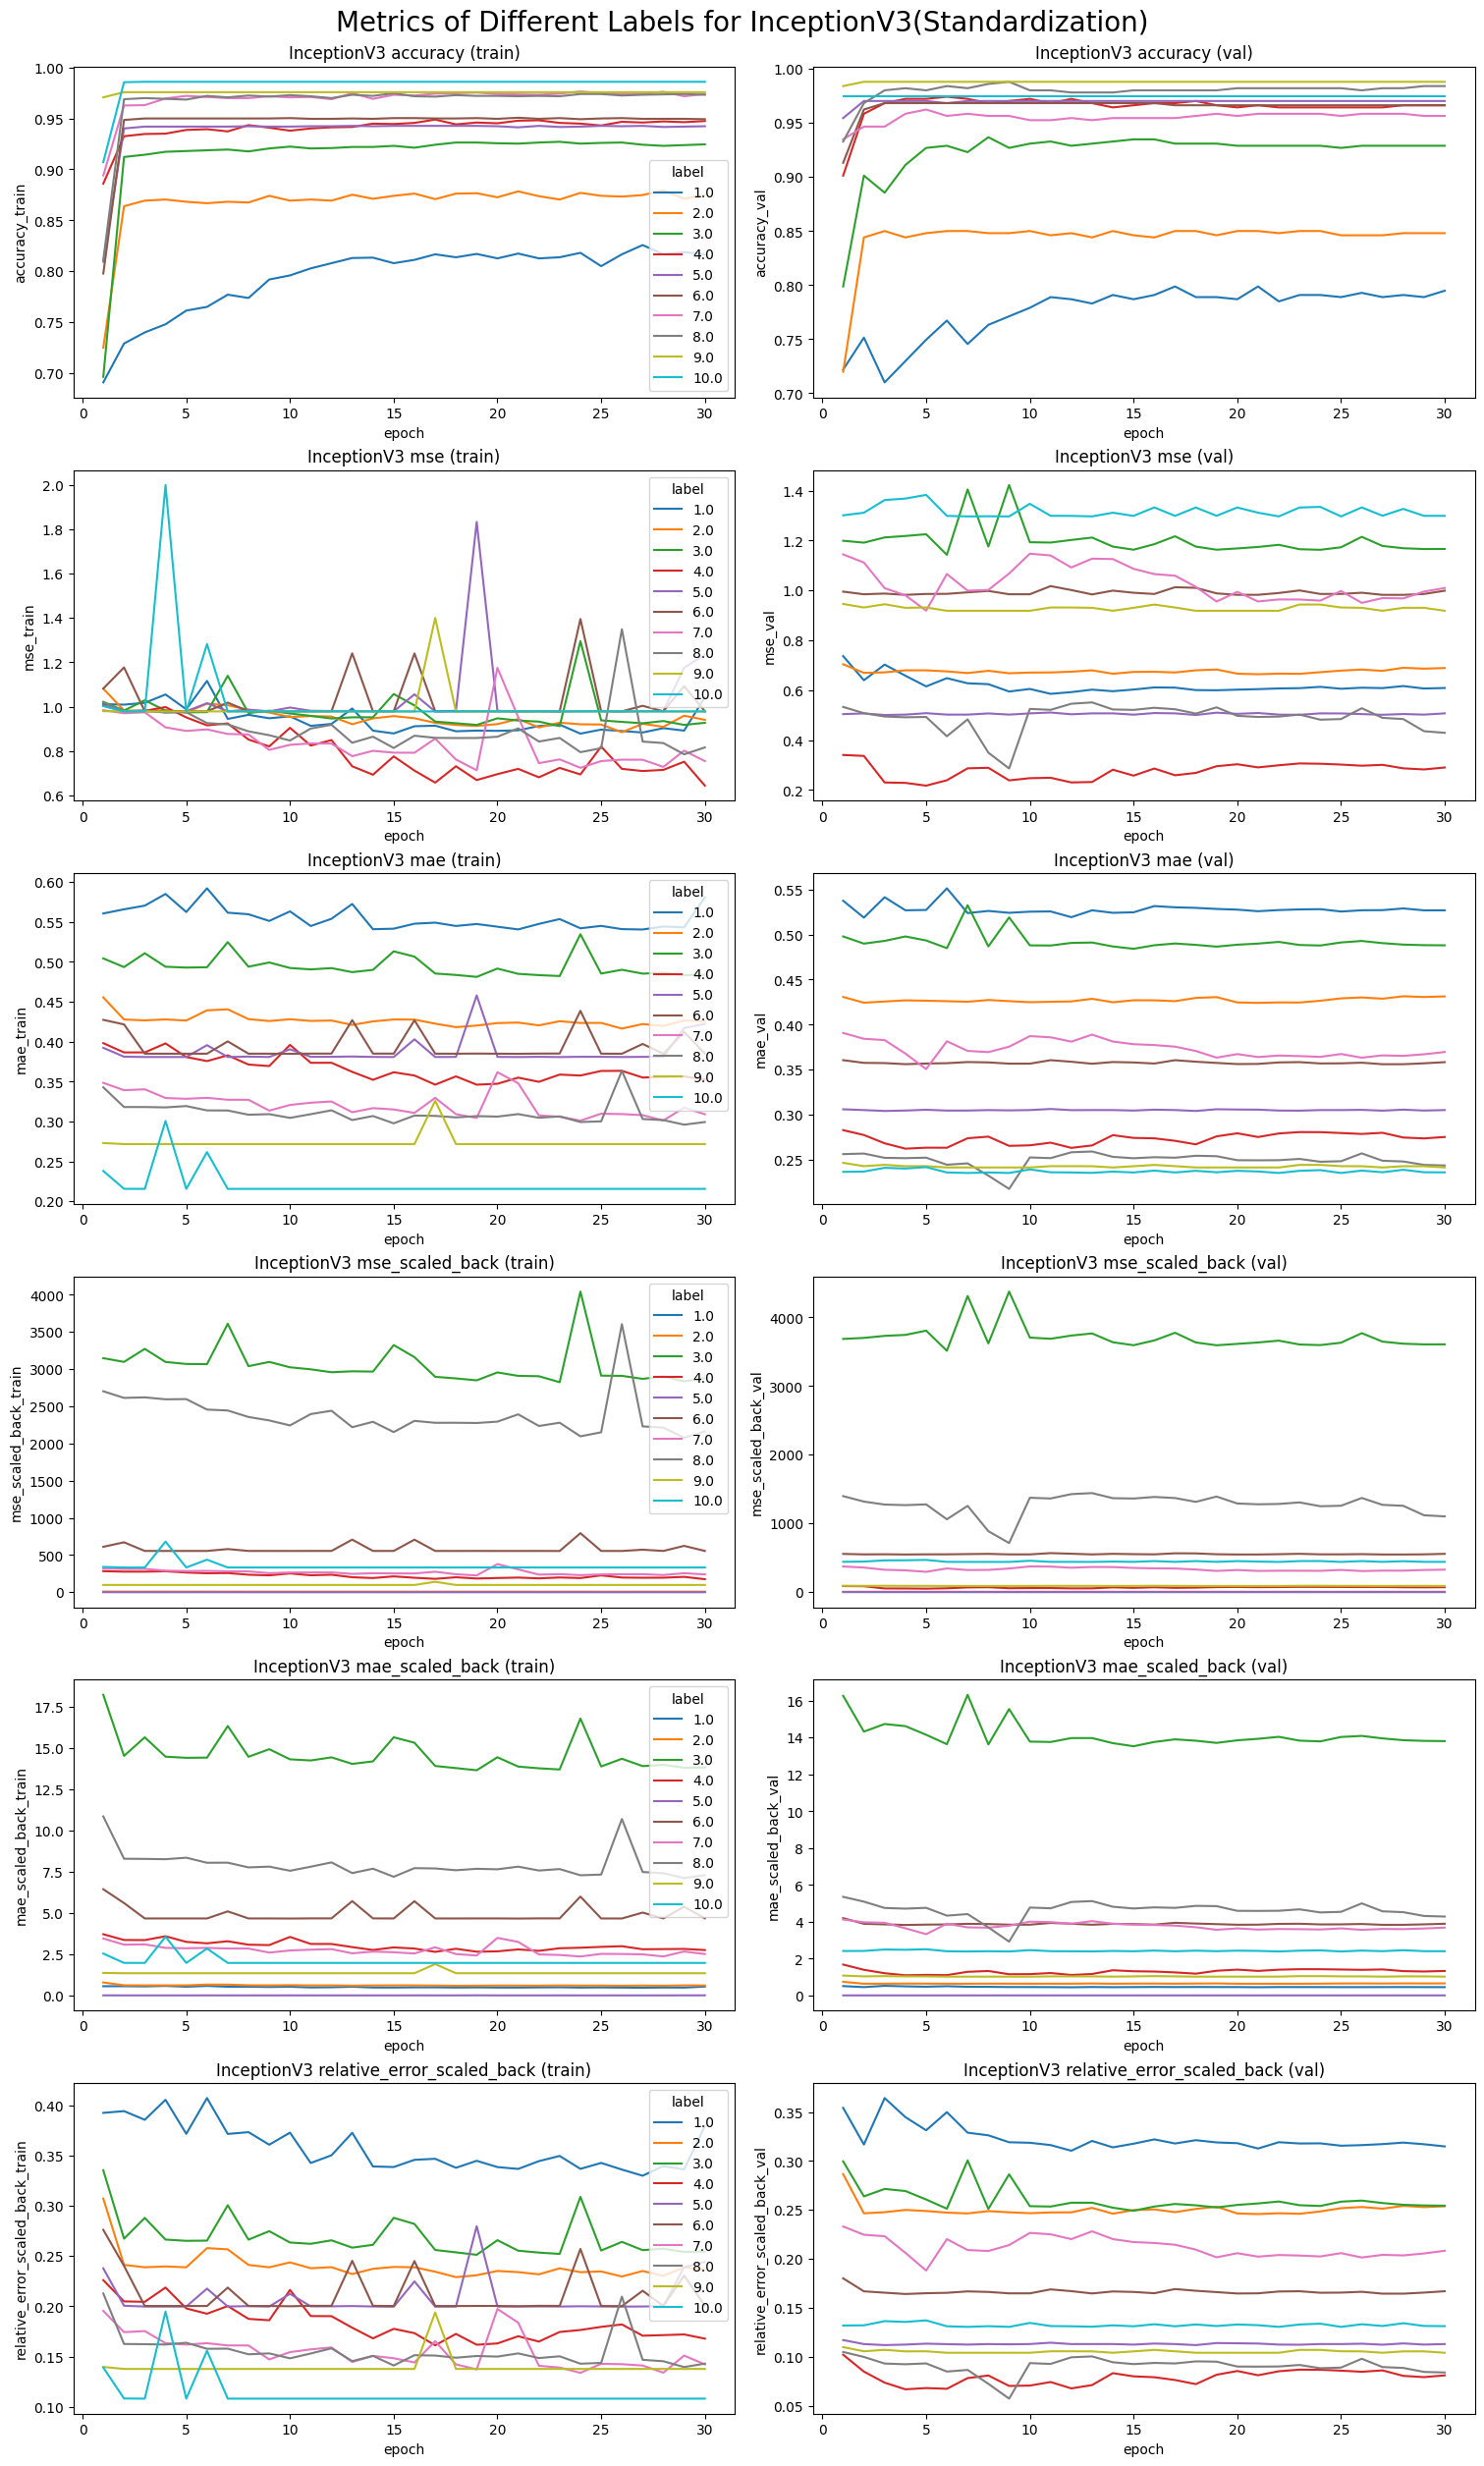

In [ ]:
import seaborn as sns
fig, axis = plt.subplots(6, 2, figsize=(15, 25), constrained_layout = True)
metrics = ['accuracy', "mse", "mae", "mse_scaled_back", "mae_scaled_back", "relative_error_scaled_back"]
datasets = ['train', 'val']
for i in range(6):
    for j in range(2):
        if j == 1:
            sns.lineplot(data=df_new, x="epoch", y="{}_{}".format(metrics[i], datasets[j]), legend=False, hue="label", ax=axis[i,j])\
                .set(title='InceptionV3 {} ({})'.format(metrics[i], datasets[j]))
        else:
            sns.lineplot(data=df_new, x="epoch", y="{}_{}".format(metrics[i], datasets[j]), legend=True, hue="label", ax=axis[i,j])\
                .set(title='InceptionV3 {} ({})'.format(metrics[i], datasets[j]))

fig.suptitle('Metrics of Different Labels for InceptionV3(Standardization)', fontsize=20);

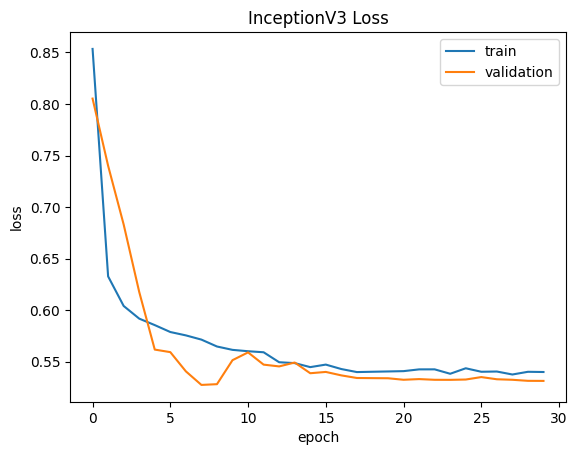

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('InceptionV3 Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
df_new

,epoch,accuracy_train,accuracy_val,mse_train,mse_val,mae_train,mae_val,mse_scaled_back_train,mse_scaled_back_val,mae_scaled_back_train,mae_scaled_back_val,relative_error_train,relative_error_val,relative_error_scaled_back_train,relative_error_scaled_back_val,loss,val_loss,label
0,1.0,0.701270,0.735700,0.971587,0.055035,2.202093,0.248899,211.285141,11.968025,32.473511,3.670429,1.520876,0.171902,22.427839,2.534983,0.521739,0.349008,1.0
1,2.0,0.755354,0.769231,0.969575,0.164353,2.579360,0.539573,210.847565,35.740883,38.036953,7.956904,1.781436,0.372656,26.270227,5.495437,0.271660,0.398645,1.0
2,3.0,0.807985,0.755424,1.331636,0.130032,3.234208,0.506060,289.582794,28.277271,47.693768,7.462696,2.233706,0.349510,32.939709,5.154112,0.218502,0.320788,1.0
3,4.0,0.842831,0.759369,1.218316,0.269303,3.105959,0.768530,264.939789,58.563641,45.802509,11.333252,2.145131,0.530785,31.633516,7.827312,0.189937,0.247827,1.0
4,5.0,0.861706,0.767258,1.208254,0.148701,3.118525,0.544954,262.751709,32.337193,45.987831,8.036250,2.153811,0.376373,31.761505,5.550238,0.177494,0.228574,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,26.0,0.992015,0.974359,0.112810,0.040684,0.223133,0.065466,9870.603516,3559.778809,66.002747,19.364927,0.012192,0.003577,3.606307,1.058075,0.052854,0.234633,10.0
296,27.0,0.993103,0.974359,0.108582,0.041401,0.221953,0.066199,9500.635742,3622.465332,65.653687,19.581638,0.012127,0.003617,3.587235,1.069916,0.053216,0.235046,10.0
297,28.0,0.991652,0.974359,0.101350,0.041331,0.219252,0.065895,8867.869141,3616.370117,64.854683,19.491802,0.011980,0.003600,3.543579,1.065008,0.051367,0.234849,10.0
298,29.0,0.994192,0.974359,0.114095,0.040220,0.203810,0.064682,9983.039062,3519.174805,60.286911,19.133053,0.011136,0.003534,3.294002,1.045406,0.050260,0.235230,10.0


# Regression

## Metrics

In [ ]:
# when scale is standardization, param1 is std, param2 is mean
# when scale is normalization, param1 is min, param2 is max
class self_MSE(tf.keras.metrics.Metric):
    """
    Calculates total MSE for a label.
    NOTE: we need to calculate average later separately
          by dividing total MSE for a label by the number of batches

    """
    def __init__(self, class_id, param1, param2, scale = "standardization", name='mse_by_label_', **kwargs):
        super(self_MSE, self).__init__(name=name, **kwargs)
        # when scale is standardization, param1 is std, param2 is mean
        # when scale is normalization, param1 is min, param2 is max
        self.scale = scale 
        self.param1 = param1
        self.param2 = param2
        self.class_id = class_id
        self.mse = self.add_weight(name='mse', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Extract calorie values from y_true
        if self.scale == "standardization":
          z_true = tf.cast(y_true[:,self.class_id], tf.float32) * self.param1[self.class_id]+self.param2[self.class_id]
          z_pred = tf.cast(y_pred[:,self.class_id], tf.float32) * self.param1[self.class_id]+self.param2[self.class_id]
        elif self.scale == "normalization":
          z_true = tf.cast(y_true[:,self.class_id], tf.float32) * (self.param2[self.class_id] - self.param1[self.class_id]) + self.param1[self.class_id]
          z_pred = tf.cast(y_pred[:,self.class_id], tf.float32) * (self.param2[self.class_id] - self.param1[self.class_id]) + self.param1[self.class_id]
        else: 
          z_true = tf.cast(y_true[:,self.class_id], tf.float32)
          z_pred = tf.cast(y_pred[:,self.class_id], tf.float32)

        regression_loss = tf.square(z_true - z_pred)
        mse = tf.reduce_mean(regression_loss, axis=0)
        self.mse.assign_add(mse)

    def result(self):
        return self.mse

    def reset_state(self):
        self.mse.assign(0.)

class self_MAE(tf.keras.metrics.Metric):
    """
    Calculates total MAE for a label.
    NOTE: we need to calculate average later separately
          by dividing total MAE for a label by the number of batches

    """
    def __init__(self, class_id, param1, param2, scale = "standardization", name='mae_by_label_', **kwargs):
        super(self_MAE, self).__init__(name=name, **kwargs)
        self.scale = scale 
        self.param1 = param1
        self.param2 = param2
        self.class_id = class_id
        self.mae = self.add_weight(name='mae', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Extract calorie values from y_true
        if self.scale == "standardization":
          z_true = tf.cast(y_true[:,self.class_id], tf.float32) * self.param1[self.class_id]+self.param2[self.class_id]
          z_pred = tf.cast(y_pred[:,self.class_id], tf.float32) * self.param1[self.class_id]+self.param2[self.class_id]
        elif self.scale == "normalization":
          z_true = tf.cast(y_true[:,self.class_id], tf.float32) * (self.param2[self.class_id] - self.param1[self.class_id]) + self.param1[self.class_id]
          z_pred = tf.cast(y_pred[:,self.class_id], tf.float32) * (self.param2[self.class_id] - self.param1[self.class_id]) + self.param1[self.class_id]
        else: 
          z_true = tf.cast(y_true[:,self.class_id], tf.float32)
          z_pred = tf.cast(y_pred[:,self.class_id], tf.float32)

        regression_loss = tf.abs(z_true - z_pred)
        mae = tf.reduce_mean(regression_loss, axis=0)
        self.mae.assign_add(mae)

    def result(self):
        return self.mae

    def reset_state(self):
        self.mae.assign(0.)


class self_relative_error(tf.keras.metrics.Metric):
    """
    Calculates total MAE for a label.
    NOTE: we need to calculate average later separately
          by dividing total MAE for a label by the number of batches

    """
    def __init__(self, class_id, std, param1, param2, scale = "standardization", name='relative_error_by_label_', **kwargs):
        super(self_relative_error, self).__init__(name=name, **kwargs)
        self.scale = scale 
        self.param1 = param1
        self.param2 = param2
        self.std = std
        self.class_id = class_id
        self.relative_error= self.add_weight(name='relative_error', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Extract calorie values from y_true
        if self.scale == "standardization":
          z_true = tf.cast(y_true[:,self.class_id], tf.float32) * self.param1[self.class_id]+self.param2[self.class_id]
          z_pred = tf.cast(y_pred[:,self.class_id], tf.float32) * self.param1[self.class_id]+self.param2[self.class_id]
        elif self.scale == "normalization":
          z_true = tf.cast(y_true[:,self.class_id], tf.float32) * (self.param2[self.class_id] - self.param1[self.class_id]) + self.param1[self.class_id]
          z_pred = tf.cast(y_pred[:,self.class_id], tf.float32) * (self.param2[self.class_id] - self.param1[self.class_id]) + self.param1[self.class_id]
        else: 
          z_true = tf.cast(y_true[:,self.class_id], tf.float32)
          z_pred = tf.cast(y_pred[:,self.class_id], tf.float32)

        regression_loss = (tf.abs(z_true - z_pred))/ self.std[self.class_id]
        relative_error = tf.reduce_mean(regression_loss, axis=0)
        self.relative_error.assign_add(relative_error)

    def result(self):
        return self.relative_error

    def reset_state(self):
        self.relative_error.assign(0.)

## Compile and Fit Model

In [ ]:
input_shape = (75, 75, 3)

# Load the InceptionV3 model with pretrained weights
model = tf.keras.models.Sequential([
            InceptionV3(input_shape = input_shape, include_top=False, weights='imagenet',  pooling = "avg"),
            tf.keras.layers.Dense(10)
        ])  

lr_decayed_fn = tf.keras.experimental.CosineDecay(initial_learning_rate=0.0001, decay_steps=1000)
optimizer_adam_cos_decay = tf.keras.optimizers.Adam(learning_rate=lr_decayed_fn)

# when scale is standardization, param1 is std, param2 is mean
# when scale is normalization, param1 is min, param2 is max
scaling_method = "normalization"
param1 = min_by_label
param2 = max_by_label
#Compile the model

model.compile(optimizer=optimizer_adam_cos_decay, loss = tf.keras.losses.MeanAbsoluteError(tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE), 
              metrics= [self_MSE(class_id = i, param1 = param1, param2 = param2, scale = None, name='mse_{}'.format(i)) for i in range(10)] +
              [self_MAE(class_id = i, param1 = param1, param2 = param2, scale = None, name='mae_{}'.format(i)) for i in range(10)] +
              [self_relative_error(class_id = i, std = std_by_label, param1 = param1, param2 = param2, scale = None, name='relative_error_{}'.format(i)) for i in range(10)] + 
              [self_MSE(class_id = i, param1 = param1, param2 = param2, scale = scaling_method, name='mse_scaled_back_{}'.format(i)) for i in range(10)]+
              [self_MAE(class_id = i, param1 = param1, param2 = param2, scale = scaling_method, name='mae_scaled_back_{}'.format(i)) for i in range(10)] +   
              [self_relative_error(class_id = i, std = std_by_label, param1 = param1, param2 = param2, scale = scaling_method, name='relative_error_scaled_back_{}'.format(i)) for i in range(10)]
              )

In [ ]:
EPOCHS = 30
#Train the model
history = model.fit(train_ds,
                    epochs=EPOCHS,
                    validation_data=val_ds,
                    verbose=1)

Epoch 1/30
44/44 [==============================] - 47s 149ms/step - loss: 0.1428 - mse_0: 3.9975 - mse_1: 4.0384 - mse_2: 5.5161 - mse_3: 3.9879 - mse_4: 2.8532 - mse_5: 2.8605 - mse_6: 3.3434 - mse_7: 3.3467 - mse_8: 2.7150 - mse_9: 3.4734 - mae_0: 6.9460 - mae_1: 6.8849 - mae_2: 8.0122 - mae_3: 6.6892 - mae_4: 5.8059 - mae_5: 6.0394 - mae_6: 6.6447 - mae_7: 6.4848 - mae_8: 5.6500 - mae_9: 5.7484 - relative_error_0: 4.7973 - relative_error_1: 2.6500 - relative_error_2: 0.1476 - relative_error_3: 0.4070 - relative_error_4: 84.3221 - relative_error_5: 0.2589 - relative_error_6: 0.3755 - relative_error_7: 0.1272 - relative_error_8: 0.5738 - relative_error_9: 0.3141 - mse_scaled_back_0: 869.3214 - mse_scaled_back_1: 2990.6934 - mse_scaled_back_2: 1194384.3750 - mse_scaled_back_3: 87765.2812 - mse_scaled_back_4: 1.6597 - mse_scaled_back_5: 147411.0469 - mse_scaled_back_6: 144588.6719 - mse_scaled_back_7: 692457.2500 - mse_scaled_back_8: 93343.2344 - mse_scaled_back_9: 303915.9375 - mae_sc

## Plot Results

In [ ]:
train_num_of_batch = math.ceil(len(X_train)/BATCH_SIZE)
val_num_of_batch = math.ceil(len(X_val)/BATCH_SIZE)
d = history.history
df_old = pd.DataFrame({'epoch':[],'mse_train':[],
                   'mse_val':[], 'mae_train':[],
                   'mae_val':[], 'mse_scaled_back_train':[],
                   'mse_scaled_back_val':[], 'mae_scaled_back_train':[],
                   'mae_scaled_back_val':[], 'relative_error_train':[], 'relative_error_val':[], 'relative_error_scaled_back_train':[], 
                   'relative_error_scaled_back_val':[], 'loss': [], 'val_loss':[],
                    'label':[]})

for idx in range(10):
    for ep in range(EPOCHS):
        
        mse_train = d['mse_{}'.format(idx)][ep]/train_num_of_batch
        mse_val = d['val_mse_{}'.format(idx)][ep]/val_num_of_batch
        mae_train = d['mae_{}'.format(idx)][ep]/train_num_of_batch
        mae_val = d['val_mae_{}'.format(idx)][ep]/val_num_of_batch
        mse_scaled_back_train = d['mse_scaled_back_{}'.format(idx)][ep]/train_num_of_batch
        mse_scaled_back_val = d['val_mse_scaled_back_{}'.format(idx)][ep]/val_num_of_batch
        mae_scaled_back_train = d['mae_scaled_back_{}'.format(idx)][ep]/train_num_of_batch
        mae_scaled_back_val = d['val_mae_scaled_back_{}'.format(idx)][ep]/val_num_of_batch
        relative_error_train = d['relative_error_{}'.format(idx)][ep]/train_num_of_batch
        relative_error_val = d['val_relative_error_{}'.format(idx)][ep]/val_num_of_batch
        relative_error_scaled_back_train = d['relative_error_scaled_back_{}'.format(idx)][ep]/train_num_of_batch
        relative_error_scaled_back_val = d['val_relative_error_scaled_back_{}'.format(idx)][ep]/val_num_of_batch
        loss_train = d['loss'][ep]
        loss_val = d['val_loss'][ep]

        temp = pd.DataFrame({'epoch':[ep+1], 'mse_train':[mse_train],
                             'mse_val':[mse_val], 'mae_train':[mae_train],
                             'mae_val':[mae_val], 'mse_scaled_back_train':[mse_scaled_back_train],
                   'mse_scaled_back_val':[mse_scaled_back_val], 'mae_scaled_back_train':[mae_scaled_back_train],
                   'mae_scaled_back_val':[mae_scaled_back_val], 'relative_error_train':[relative_error_train], 'relative_error_val':[relative_error_val], 'relative_error_scaled_back_train':[ relative_error_scaled_back_train], 
                   'relative_error_scaled_back_val':[relative_error_scaled_back_val], 
                   'loss': [loss_train], 'val_loss':[loss_val],
                             'label':[idx+1]})
        df_old = df_old.append(temp, ignore_index=True)

df_old.label = df_old.label.astype(str)

<ipython-input-94-db07b49b59a4>:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_old = df_old.append(temp, ignore_index=True)
<ipython-input-94-db07b49b59a4>:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_old = df_old.append(temp, ignore_index=True)
<ipython-input-94-db07b49b59a4>:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_old = df_old.append(temp, ignore_index=True)
<ipython-input-94-db07b49b59a4>:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_old = df_old.append(temp, ignore_index=True)
<ipython-input-94-db07b49b59a4>:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in 

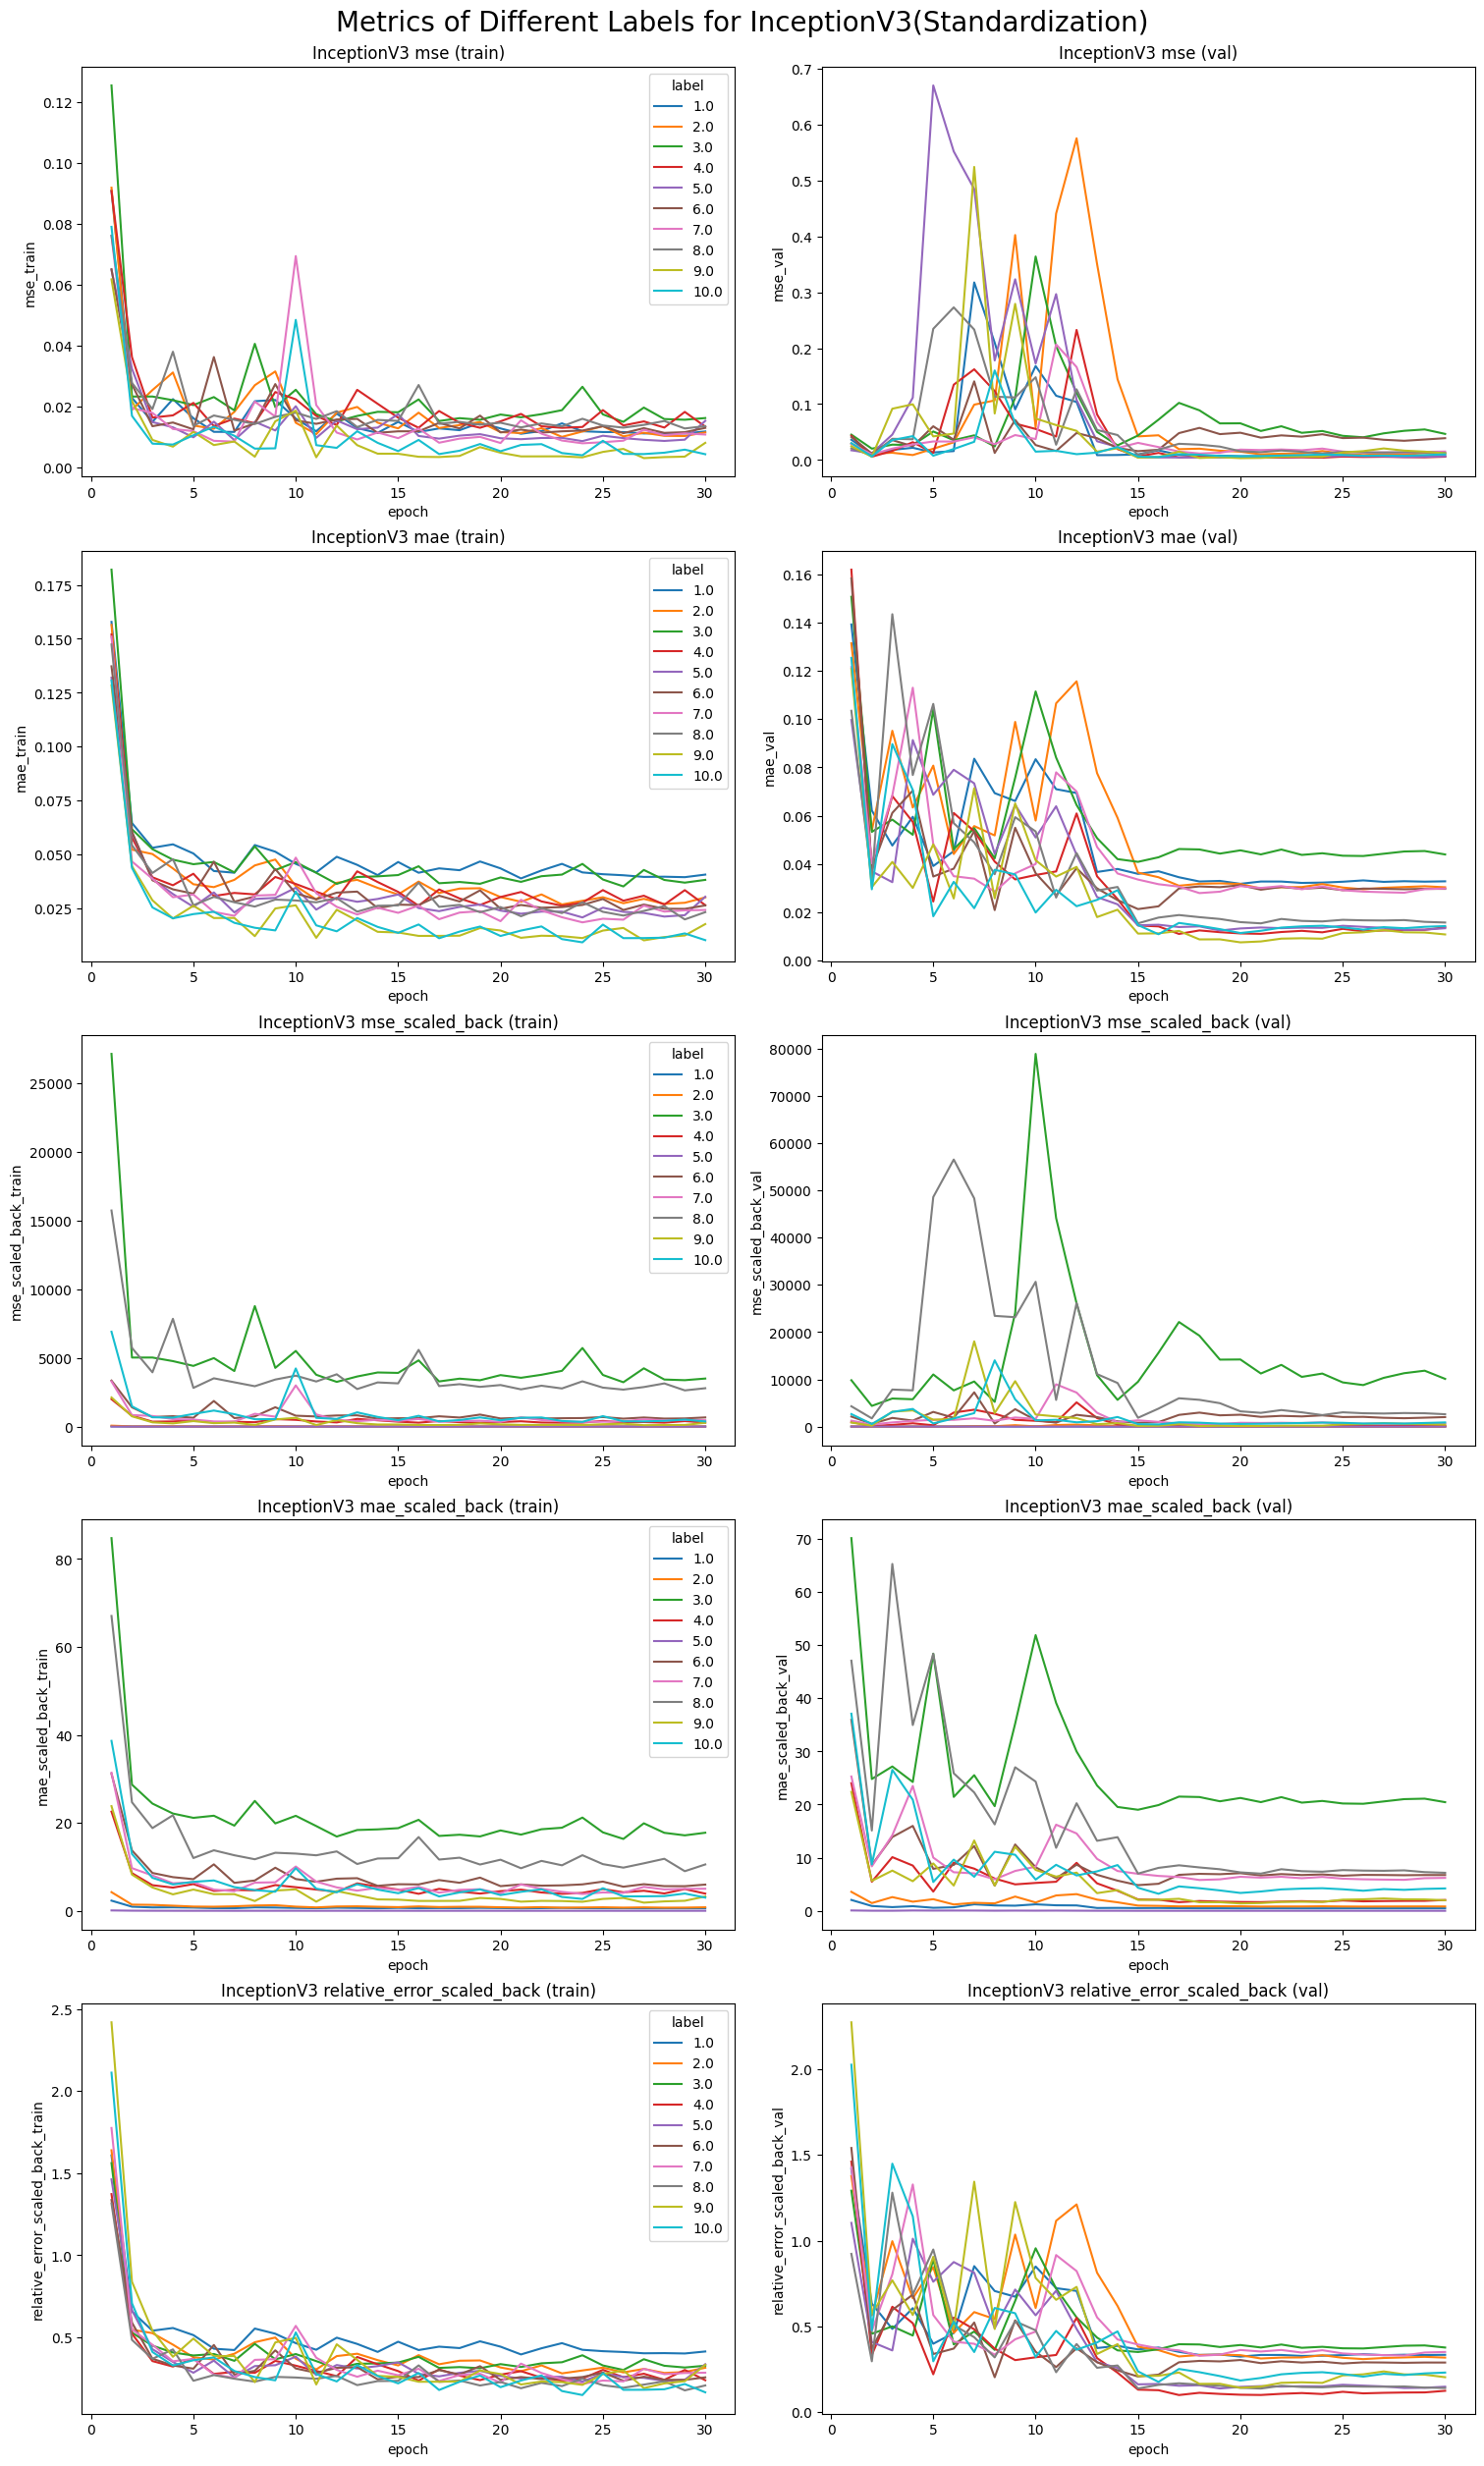

In [ ]:
import seaborn as sns
fig, axis = plt.subplots(5, 2, figsize=(15, 25), constrained_layout = True)
metrics = ["mse", "mae", "mse_scaled_back", "mae_scaled_back", "relative_error_scaled_back"]
datasets = ['train', 'val']
for i in range(5):
    for j in range(2):
        if j == 1:
            sns.lineplot(data=df_old, x="epoch", y="{}_{}".format(metrics[i], datasets[j]), legend=False, hue="label", ax=axis[i,j])\
                .set(title='InceptionV3 {} ({})'.format(metrics[i], datasets[j]))
        else:
            sns.lineplot(data=df_old, x="epoch", y="{}_{}".format(metrics[i], datasets[j]), legend=True, hue="label", ax=axis[i,j])\
                .set(title='InceptionV3 {} ({})'.format(metrics[i], datasets[j]))

fig.suptitle('Metrics of Different Labels for InceptionV3(Standardization)', fontsize=20);

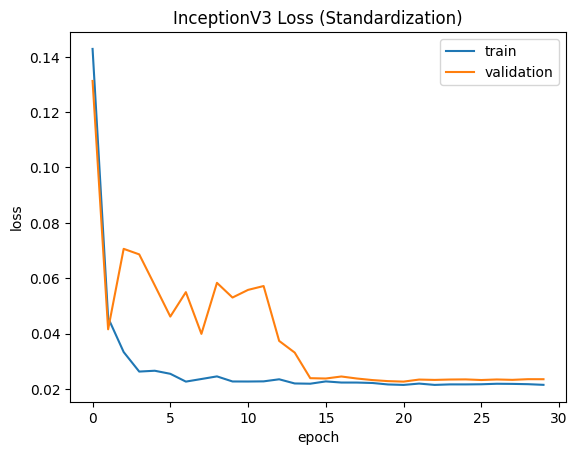

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('InceptionV3 Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

# Comparison

## After standarization

By comparing mse_scaled_back_val, mae_scaled_back_val, and relative_error_back_val from last epoch using old method(solely regression) and new method(classification + regression) using std-mean standardization, we can find that for label 1,2,4,5,7,8,10, the new method has smaller mse_scaled_back_val. For label 2,4,5,7,8,9,10, the new method has smaller mae_scaled_back_val. For label 2,4,7,8,9,10, the new method has smaller relative_error_back_val.

### Comparision of mse_scaled_back_val

In [ ]:
df_old[df_old["epoch"] == 30]["mse_scaled_back_val"]

29        1.480716
59        4.987154
89     3731.718750
119      90.415085
149       0.002425
179     564.501465
209     370.105469
239    1402.580322
269      89.972816
299     440.481171
Name: mse_scaled_back_val, dtype: float64

In [ ]:
df_new[df_new["epoch"] == 30]["mse_scaled_back_val"]

29        1.162285
59        4.442680
89     3310.386719
119      96.795181
149       0.002578
179     579.786377
209     295.215515
239     904.316040
269      91.163704
299     467.851440
Name: mse_scaled_back_val, dtype: float64

In [ ]:
df_old[df_old["epoch"] == 30]["mse_scaled_back_val"] <= df_new[df_new["epoch"] == 30]["mse_scaled_back_val"]

29     False
59     False
89     False
119     True
149     True
179     True
209    False
239    False
269     True
299     True
Name: mse_scaled_back_val, dtype: bool

### Comparision of mae_scaled_back_val

In [ ]:
df_old[df_old["epoch"] == 30]["mae_scaled_back_val"]

29      0.459477
59      0.652088
89     14.388117
119     1.457408
149     0.008356
179     4.135937
209     3.999250
239     5.332305
269     1.070906
299     2.461862
Name: mae_scaled_back_val, dtype: float64

In [ ]:
df_new[df_new["epoch"] == 30]["mae_scaled_back_val"]

29      0.489606
59      0.639023
89     13.743342
119     1.520327
149     0.008619
179     4.249448
209     3.498826
239     3.539260
269     1.040579
299     2.632006
Name: mae_scaled_back_val, dtype: float64

In [ ]:
df_old[df_old["epoch"] == 30]["mae_scaled_back_val"] <= df_new[df_new["epoch"] == 30]["mae_scaled_back_val"]

29      True
59     False
89     False
119     True
149     True
179     True
209    False
239    False
269    False
299     True
Name: mae_scaled_back_val, dtype: bool

### Comparison of relative_error_scaled_back_val

In [ ]:
df_old[df_old["epoch"] == 30]["relative_error_scaled_back_val"]

29     0.317338
59     0.250992
89     0.265034
119    0.088667
149    0.121365
179    0.177333
209    0.225985
239    0.104585
269    0.108751
299    0.134513
Name: relative_error_scaled_back_val, dtype: float64

In [ ]:
df_new[df_new["epoch"] == 30]["relative_error_scaled_back_val"]

29     0.338146
59     0.245963
89     0.253157
119    0.092495
149    0.125173
179    0.182200
209    0.197707
239    0.069417
269    0.105671
299    0.143810
Name: relative_error_scaled_back_val, dtype: float64

In [ ]:
df_old[df_old["epoch"] == 30]["relative_error_scaled_back_val"] <= df_new[df_new["epoch"] == 30]["relative_error_scaled_back_val"]

29      True
59     False
89     False
119     True
149     True
179     True
209    False
239    False
269    False
299     True
Name: relative_error_scaled_back_val, dtype: bool

## After Normalization

For min-max Normalization, by comparing the metrics from last epoch, we can find that the old method outperform the new method in mse_scaled_back_val only for label 3 and 5, in mae_scaled_back_val and relative_error_scaled_back_val only for label 1 and 2. 

### Comparision of mse_scaled_back_val

In [ ]:
df_old[df_old["epoch"] == 30]["mse_scaled_back_val"]

29         1.518025
59         8.510077
89     10096.632812
119      128.651260
149        0.003852
179     2008.090210
209      650.520996
239     2610.391357
269      407.868011
299      880.105652
Name: mse_scaled_back_val, dtype: float64

In [ ]:
df_new[df_new["epoch"] == 30]["mse_scaled_back_val"]

29        5.235374
59        7.909443
89     4593.277344
119     110.734245
149       0.003187
179     497.731384
209     333.058807
239    1461.042480
269      89.976830
299     452.808136
Name: mse_scaled_back_val, dtype: float64

In [ ]:
df_old[df_old["epoch"] == 30]["mse_scaled_back_val"] <= df_new[df_new["epoch"] == 30]["mse_scaled_back_val"]

29      True
59     False
89     False
119    False
149    False
179    False
209    False
239    False
269    False
299    False
Name: mse_scaled_back_val, dtype: bool

### Comparision of mae_scaled_back_val

In [ ]:
df_old[df_old["epoch"] == 30]["mae_scaled_back_val"]

29      0.483859
59      0.825933
89     20.446560
119     2.041155
149     0.010201
179     6.740998
209     6.207372
239     7.160519
269     2.003433
299     4.220034
Name: mae_scaled_back_val, dtype: float64

In [ ]:
df_new[df_new["epoch"] == 30]["mae_scaled_back_val"]

29      1.041490
59      0.909239
89     16.680567
119     1.646814
149     0.010026
179     3.891191
209     3.751297
239     4.829247
269     1.026562
299     2.447705
Name: mae_scaled_back_val, dtype: float64

In [ ]:
df_old[df_old["epoch"] == 30]["mae_scaled_back_val"]<= df_new[df_new["epoch"] == 30]["mae_scaled_back_val"]

29      True
59      True
89     False
119    False
149    False
179    False
209    False
239    False
269    False
299    False
Name: mae_scaled_back_val, dtype: bool

### Comparison of relative_error_scaled_back_val

In [ ]:
df_old[df_old["epoch"] == 30]["relative_error_scaled_back_val"]

29     0.334177
59     0.317906
89     0.376632
119    0.124182
149    0.148161
179    0.289028
209    0.350759
239    0.140442
269    0.203450
299    0.230577
Name: relative_error_scaled_back_val, dtype: float64

In [ ]:
df_new[df_new["epoch"] == 30]["relative_error_scaled_back_val"]

29     0.719305
59     0.349970
89     0.307261
119    0.100191
149    0.145609
179    0.166839
209    0.211974
239    0.094718
269    0.104248
299    0.133740
Name: relative_error_scaled_back_val, dtype: float64

In [ ]:
df_old[df_old["epoch"] == 30]["relative_error_scaled_back_val"] <= df_new[df_new["epoch"] == 30]["relative_error_scaled_back_val"]

29      True
59      True
89     False
119    False
149    False
179    False
209    False
239    False
269    False
299    False
Name: relative_error_scaled_back_val, dtype: bool